# Data Wrangling Slot Machine Data

## 1. 게임 이미지 데이터 처리

In [4]:
# 필요한 패키지 불러오기

import os
import glob
import cv2
import natsort
from os import listdir

import matplotlib.pyplot as plt
%matplotlib inline

data_path = '../data/slot_machine/'

In [2]:
# cv2 패키지로 이미지를 읽는 함수 생성

def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return img

In [3]:
# 이미지를 보여주는 함수 생성

def show_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2는 이미지 파일을 bgr로 읽기때문에 rgb로 변환
    plt.figure(figsize=(25, 12))
    plt.imshow(img)
    plt.show()

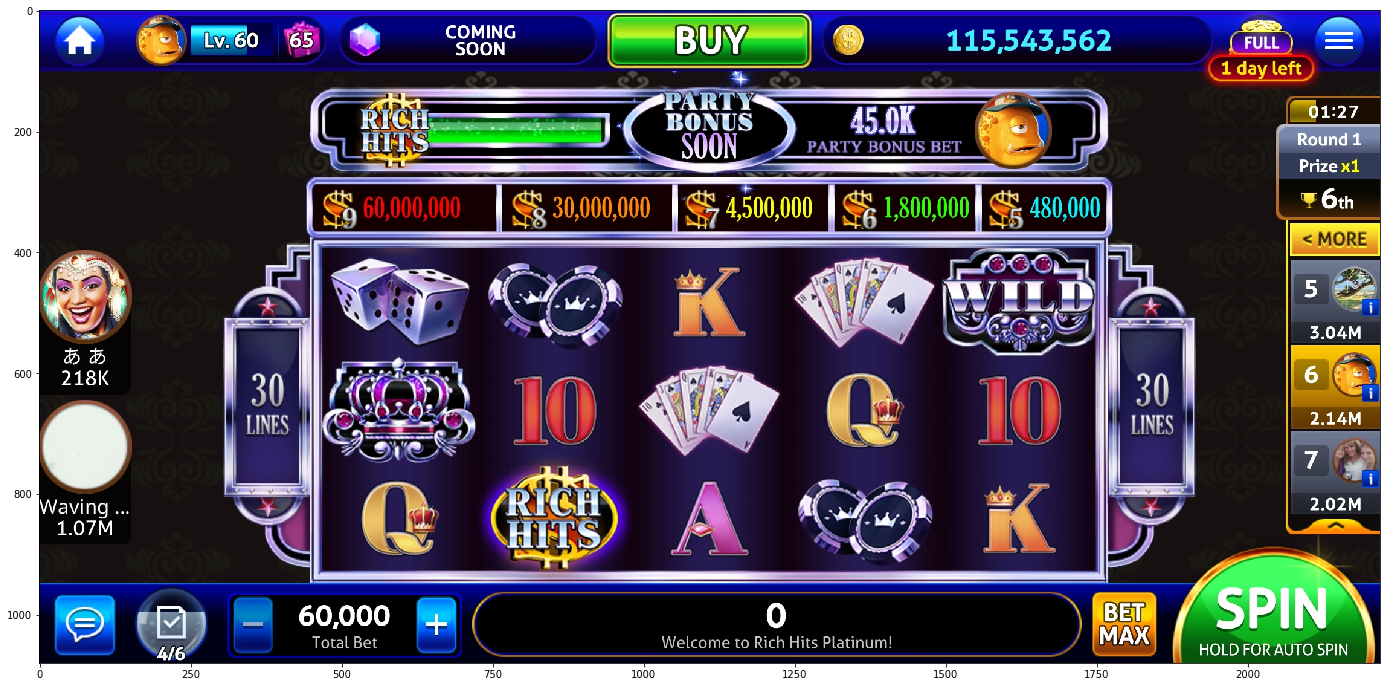

In [4]:
# 예시 이미지 불러오기

img_ex = read_image(data_path + 'platinum/platinum_1.jpg')
show_image(img_ex)

In [5]:
# 3 X 5의 슬롯 화면 외에 나머지 부분을 잘라내는 함수 생성

def trim_image (img):
    x = 470; y = 390;
    w = 1280; h = 540;
    img_trim = img[y:y+h, x:x+w]
    #cv2.imwrite('img_ex_trim.jpg', img_trim)
    return img_trim

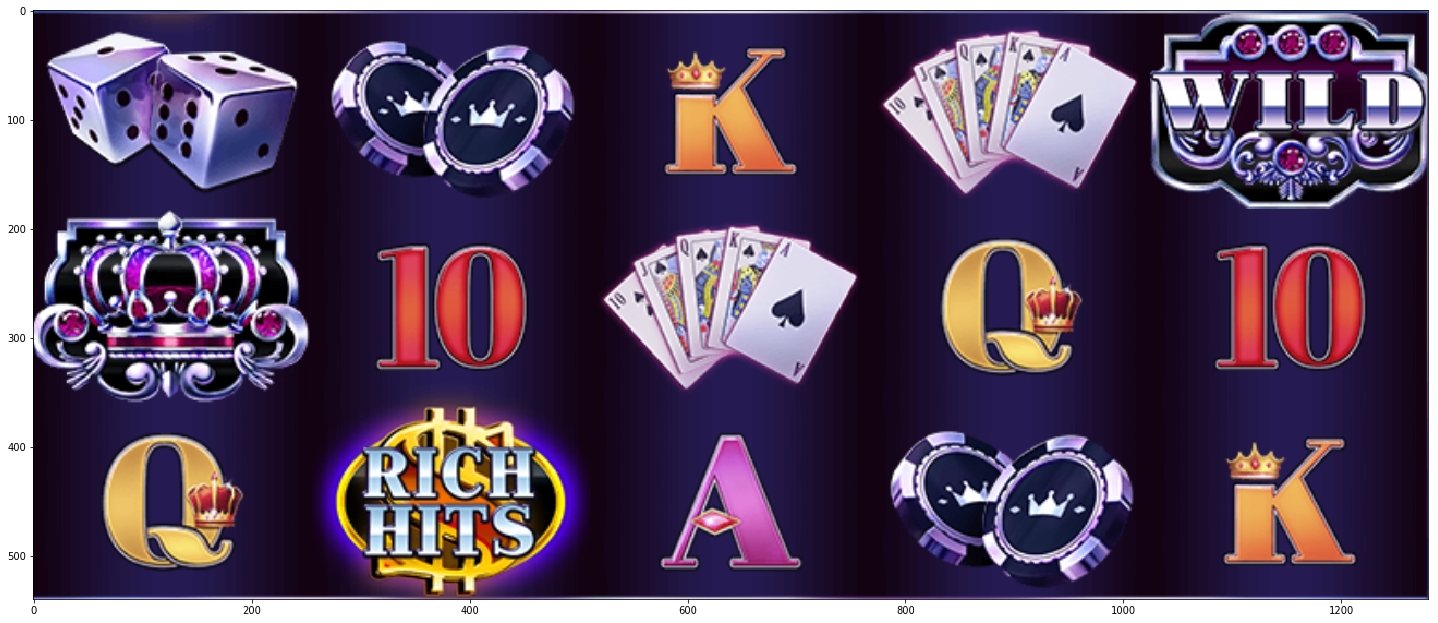

In [6]:
# 예시 이미지 자르기

img_trim = trim_image(img_ex)
show_image(img_trim)

In [11]:
# 가져올 게임의 목록

game_list = ['platinum']

In [12]:
# 슬롯부분 외의 이미지를 3 X 5 등분 하는 함수 생성

def image_segmentation(img, image_name, game):
    height , width, channels = img.shape # 높이, 너비, 채널 저장
    height , width = height // 3 , width // 5 # 높이는 3등분, 너비는 5등분 하기 위해 각각 3과 5로 나누기
    count = 0
    for col in range(5):
        for row in range(3):
            img_seg = img[height*row:height*(row+1), width*col:width*(col+1)]
            seg_save_path = data_path + game + '_processed'
            cv2.imwrite(os.path.join(seg_save_path, str(os.path.splitext(image_name)[0]) + '_' + str(count) + '.jpg'), img_seg)
            count += 1

In [13]:
# 생성한 이미지 처리 함수들을 이용해 이미지 가공

def image_processing(game):
    #for game in game_list:
    files = listdir(data_path + game + '/.') # 이미지 파일 불러오기
    files_sort = natsort.natsorted(files) # 숫자 오름차순으로 정렬
    for image_name in files_sort:
        img = read_image(data_path + game + '/' + image_name)
        img = trim_image(img)
        image_segmentation(img, image_name, game)

In [38]:
# 이미지 처리

image_processing('platinum')

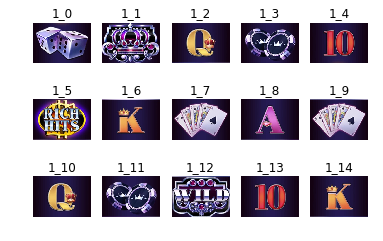

In [31]:
# 처리한 이미지 예시 시각화

for x in range(15):
    plt.subplot(3, 5, x+1)
    image = read_image(data_path + 'platinum_processed/platinum_1_{}.jpg'.format(x))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title('1_{}'.format(x))
    
plt.show()

## 2. 정보를 담은 CSV 파일 생성

In [1]:
import pandas as pd

In [2]:
# train 데이터를 담을 DataFrame 생성

pl_train = pd.DataFrame(columns=['img', 'classname'])

In [5]:
# 이미지를 분류해놓은 폴더 리스트 불러오기

class_list = natsort.natsorted(listdir(data_path + 'platinum_train/.'))
class_list

['c00_10',
 'c01_J',
 'c02_Q',
 'c03_K',
 'c04_A',
 'c05_Ca',
 'c06_Co',
 'c07_D',
 'c08_Cr',
 'c09_W',
 'c10_R']

In [6]:
# DataFrame에 데이터 파일명, class 저장

for n, c in enumerate(class_list):
    names = natsort.natsorted(listdir(data_path + 'platinum_train/' + c + '/.'))
    for name in names:
        pl_train.loc[len(pl_train),:] = [name, c.split('_')[1]]

In [7]:
pl_train.head()

,img,classname
0,platinum_0_6.jpg,10
1,platinum_0_9.jpg,10
2,platinum_0_11.jpg,10
3,platinum_0_12.jpg,10
4,platinum_1_4.jpg,10


## 3. 이미지 분류를 위한 CNN 모델 설계

In [8]:
# 필요한 패키지 불러오기

import keras
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

import shutil
import numpy as np
import subprocess
import os
from glob import glob
from datetime import datetime

C:\Users\Lee\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
nfolds = 2 # 교차검증 fold 수
n_class = 11 # class 종류 수
test_nfolds = 1 # 테스트 fold 수
suffix = '.d{}'.format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S")) # 현재 년-월-일-시간-분-초 저장
labels = ['c00_10', 'c01_J', 'c02_Q', 'c03_K', 'c04_A', 'c05_Ca', 'c06_Co', 'c07_D', 'c08_Cr', 'c09_W', 'c10_R'] # class 종류 리스트 생성

In [10]:
temp_train_fold = data_path + 'platinum_keras/train_{}'.format(suffix) # train 데이터를 저장할 경로
temp_valid_fold = data_path + 'platinum_keras/valid_{}'.format(suffix) # valid 데이터를 저장할 경로
train_path = data_path + 'platinum_train' # train 데이터 경로
test_path = data_path + 'platinum_test' # test 데이터 경로
print(temp_train_fold, temp_valid_fold, train_path, test_path)

../data/slot_machine/platinum_keras/train_.d2019-10-04-18-18-29 ../data/slot_machine/platinum_keras/valid_.d2019-10-04-18-18-29 ../data/slot_machine/platinum_train ../data/slot_machine/platinum_test


In [11]:
# 모델을 불러오는 함수 생성

def get_model():
    # vgg16 모델의 convolution 레이어로 구성된 앞부분만 불러오기
    base_model = keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=(256,180,3))
    
    out = Flatten()(base_model.output)
    out = Dense(256, activation='relu')(out)
    out = Dropout(0.5)(out)
    output = Dense(11, activation='softmax')(out)
    model = Model(inputs=base_model.input, outputs=output)

    # SGD Optimizer를 사용하여, 모델을 compile한다
    sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# 폴더를 비우는 함수 생성

def _clear_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)

In [13]:
# train 데이터와 valid 데이터를 분리하는 함수 생성

def generate_split():
    def _generate_temp_folder(root_path):
        _clear_dir(root_path)
        for l in labels:
            os.mkdir('{}/{}'.format(root_path,l))
    _generate_temp_folder(temp_train_fold)
    _generate_temp_folder(temp_valid_fold)
    
    train_samples = 0
    valid_samples = 0
    
    for label in labels:
        files = glob('{}/{}/*.jpg'.format(train_path, label))
        for fl in files:
            if np.random.randint(nfolds) != 1:
                shutil.copy(fl, temp_train_fold + './' + label)
                train_samples += 1
            else:
                shutil.copy(fl, temp_valid_fold + './' + label)
                valid_samples += 1
            #subprocess.call(cmd, stderr=subprocess.STDOUT, shell=True)
    print('# {} train samples | {} valid samples'.format(train_samples, valid_samples))
    return train_samples, valid_samples

In [14]:
datagen = ImageDataGenerator()

# test generator 생성
test_generator = datagen.flow_from_directory(
        directory='../data/slot_machine/platinum_test/',
        target_size=(256,180),
        batch_size=1,
        class_mode=None,
        shuffle=False)

# test 이미지 파일의 이름을 담은 리스트 생성
test_id =  [os.path.basename(fl) for fl in glob('{}/imgs/*.jpg'.format(test_path))]

# nfolds 수만큼 교차검증
for fold in range(nfolds):
    print('fold ', fold)
    
    model = get_model()
    
    train_samples, valid_samples = generate_split()
    
    train_generator = datagen.flow_from_directory(
                directory=temp_train_fold,
                target_size=(256,180),
                batch_size=4,
                class_mode='categorical',
                seed=2019)

    valid_generator = datagen.flow_from_directory(
                directory=temp_valid_fold,
                target_size=(256,180),
                batch_size=4,
                class_mode='categorical',
                seed=2019)
    
    #weight_path = 'cache/c{}/mini_weight.fold_{}.h5'.format(suffix,fold)
    #callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0), ModelCheckpoint(weight_path, monitor='val_loss', save_best_only=True, verbose=0)]
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0)]
    
    model.fit_generator(
            train_generator,
            steps_per_epoch=train_samples/8,
            epochs=10,
            validation_data=valid_generator,
            validation_steps=valid_samples/8,
            shuffle=True,
            callbacks=callbacks,
            verbose=1)
    
    for j in range(test_nfolds):
        preds = model.predict_generator(
                    test_generator,
                    steps=len(test_id),
                    verbose=1)
        
        if j == 0:
            result = pd.DataFrame(preds, columns=labels)
        else:
            result += pd.DataFrame(preds, columns=labels)
    
    result /= test_nfolds
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    
    sub_file = data_path + 'platinum_result/fold{}.csv'.format(fold)
    result.to_csv(sub_file, index=False)
    
    shutil.rmtree(temp_train_fold)
    shutil.rmtree(temp_valid_fold)

Found 28940 images belonging to 1 classes.
fold  0
# 512 train samples | 538 valid samples
Found 512 images belonging to 11 classes.
Found 538 images belonging to 11 classes.
Epoch 1/10
64/64 [==============================] - 36s 563ms/step - loss: 2.0045 - acc: 0.3438 - val_loss: 1.1658 - val_acc: 0.6691
Epoch 2/10
64/64 [==============================] - 10s 161ms/step - loss: 0.9869 - acc: 0.6914 - val_loss: 0.0860 - val_acc: 1.0000
Epoch 3/10
64/64 [==============================] - 10s 158ms/step - loss: 0.2838 - acc: 0.9180 - val_loss: 0.0287 - val_acc: 1.0000
Epoch 4/10
64/64 [==============================] - 10s 158ms/step - loss: 0.1724 - acc: 0.9414 - val_loss: 0.0470 - val_acc: 0.9963
Epoch 5/10
64/64 [==============================] - 10s 158ms/step - loss: 0.0879 - acc: 0.9727 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 6/10
64/64 [==============================] - 10s 160ms/step - loss: 0.1233 - acc: 0.9727 - val_loss: 5.4355e-04 - val_acc: 1.0000
Epoch 7/10
64/64 [=====

In [15]:
#모델 저장

base_model_json = model.to_json()
with open("cnn_model/baseline_model2_{}.json".format(suffix), "w") as json_file : 
    json_file.write(base_model_json)
print("Saved model to disk")

model.save_weights("cnn_model/baseline_model2_h5_{}.h5".format(suffix))
print("Saved model to disk")

Saved model to disk
Saved model to disk


In [26]:
#단순 앙상블

ensemble = 0
for fold in range(nfolds):
    ensemble += pd.read_csv(data_path + 'platinum_result/fold{}.csv'.format(fold), index_col=-1).values * 1. / nfolds
ensemble = pd.DataFrame(ensemble, columns=labels)
ensemble.loc[:, 'img'] = pd.Series(test_id, index=ensemble.index)
result_file = data_path + 'platinum_result/final_{}.csv'.format(suffix)
ensemble.to_csv(result_file, index=False) # 결과 파일 저장

## 4. 결과 값을 담을 CSV 파일 생성

In [28]:
# 저장한 파일 불러오기

final_result = pd.read_csv(result_file)
final_result.head()

,c00_10,c01_J,c02_Q,c03_K,c04_A,c05_Ca,c06_Co,c07_D,c08_Cr,c09_W,c10_R,img
0,1.708090e-06,9.999811e-01,7.002358e-07,7.370569e-06,3.509663e-06,2.109906e-06,2.326762e-07,4.022479e-07,7.432607e-07,1.230093e-06,7.531207e-07,platinum_1000_0.jpg
1,1.780770e-05,9.990235e-01,1.094720e-05,2.038293e-04,5.634361e-05,2.423906e-04,5.065858e-05,5.475426e-05,1.451998e-04,1.638081e-04,3.076142e-05,platinum_1000_1.jpg
2,2.030801e-05,9.991122e-01,7.319111e-06,2.223263e-04,6.720573e-05,1.302525e-04,4.245934e-05,4.205390e-05,1.681005e-04,1.557177e-04,3.212447e-05,platinum_1000_10.jpg
3,7.285592e-07,9.999824e-01,6.027867e-07,8.285221e-06,3.734715e-06,1.670240e-06,2.281047e-07,5.937737e-07,4.473158e-07,7.125428e-07,5.776201e-07,platinum_1000_11.jpg
4,1.062155e-09,2.670299e-11,1.000000e+00,3.169373e-09,3.151265e-09,5.546697e-10,1.634527e-13,1.169837e-08,2.809057e-13,6.018312e-16,6.226446e-09,platinum_1000_12.jpg


In [29]:
# 파일 이름 숫자 오름차순으로 정렬

final_result['img'] = pd.Categorical(final_result['img'], ordered=True, categories=natsort.natsorted(final_result['img']))
final_result = final_result.sort_values('img')
final_result.reset_index(drop=True).head()

,c00_10,c01_J,c02_Q,c03_K,c04_A,c05_Ca,c06_Co,c07_D,c08_Cr,c09_W,c10_R,img
0,5.377807e-10,1.071034e-09,5.307387e-11,1.020953e-10,6.721215e-09,5.892797e-07,9.999991e-01,1.935057e-10,3.776017e-11,3.089846e-07,2.548309e-09,platinum_70_0.jpg
1,1.386995e-09,7.779626e-09,1.822739e-08,1.670404e-06,9.999982e-01,4.684379e-11,6.414271e-09,1.310466e-09,4.669320e-10,7.842902e-10,5.634626e-09,platinum_70_1.jpg
2,1.210340e-11,1.927109e-10,1.528005e-10,1.465242e-14,1.155200e-09,5.464158e-08,9.661211e-10,9.999999e-01,3.519447e-11,2.984766e-10,2.252184e-09,platinum_70_2.jpg
3,9.146446e-07,9.999845e-01,5.324060e-07,6.568783e-06,3.206230e-06,2.160082e-06,2.109992e-07,5.691702e-07,3.363518e-07,4.503389e-07,5.991694e-07,platinum_70_3.jpg
4,2.865769e-10,7.459139e-12,1.000000e+00,1.772413e-09,1.933054e-09,6.537788e-10,2.061965e-13,8.907513e-09,1.223787e-13,5.709115e-16,2.860337e-09,platinum_70_4.jpg


In [30]:
# 예측값이 가장 높은 class로 labeling

length = len(final_result[:])
class_name = [0]*length

for x in range(length):
    maxv = final_result.iloc[x:x+1,0:11].values.max()
    if maxv == final_result.iloc[x:x+1,0].values:
        class_name[x] = '10'
    elif maxv == final_result.iloc[x:x+1,1].values:
        class_name[x] = 'J'
    elif maxv == final_result.iloc[x:x+1,2].values:
        class_name[x] = 'Q'
    elif maxv == final_result.iloc[x:x+1,3].values:
        class_name[x] = 'K'
    elif maxv == final_result.iloc[x:x+1,4].values:
        class_name[x] = 'A'
    elif maxv == final_result.iloc[x:x+1,5].values:
        class_name[x] = 'Ca'
    elif maxv == final_result.iloc[x:x+1,6].values:
        class_name[x] = 'Co'
    elif maxv == final_result.iloc[x:x+1,7].values:
        class_name[x] = 'D'
    elif maxv == final_result.iloc[x:x+1,8].values:
        class_name[x] = 'Cr'
    elif maxv == final_result.iloc[x:x+1,9].values:
        class_name[x] = 'W'
    else:
        class_name[x] = 'R'

In [31]:
class_name[:5]

['Co', 'A', 'D', 'J', 'Q']

In [32]:
# test 결과를 담을 DataFrame 생성

pl_test = pd.DataFrame(columns=['img', 'classname'])

In [33]:
# 예측 class 저장

pl_test['img'] = final_result['img']
pl_test['classname'] = pd.Series(class_name)

In [34]:
pl_test.head()

,img,classname
24140,platinum_70_0.jpg,A
24141,platinum_70_1.jpg,A
24147,platinum_70_2.jpg,A
24148,platinum_70_3.jpg,A
24149,platinum_70_4.jpg,W


In [35]:
# train으로 쓰인 데이터와 test 결과를 병합

pl_all = pd.concat([pl_train, pl_test])
pl_all.head()

,img,classname
0,platinum_0_6.jpg,10
1,platinum_0_9.jpg,10
2,platinum_0_11.jpg,10
3,platinum_0_12.jpg,10
4,platinum_1_4.jpg,10


In [38]:
# 파일 이름으로 정렬

pl_all['img'] = pd.Categorical(pl_all['img'], ordered=True, categories=natsort.natsorted(pl_all['img']))
pl_all = pl_all.sort_values('img')
pl_all.reset_index(drop=True, inplace=True)
pl_all.head()

,img,classname
0,platinum_0_0.jpg,Ca
1,platinum_0_1.jpg,A
2,platinum_0_2.jpg,Q
3,platinum_0_3.jpg,W
4,platinum_0_4.jpg,A


In [50]:
# DataFrame 저장

pl_all.to_csv(data_path + '/platinum_csv/pl_all.csv', index=False)